# MNIST 손글씨 이미지 분류 (MLP)

## 0 Load Module & Setting

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)

## 1. Data Preparation

In [2]:
# 이미지를 tensor로 변환 (파이토치는 텐서만을 입력으로 받음)
training_data = MNIST(root="./", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="./", train=False, download=True, transform=ToTensor())

print(len(training_data))
print(len(test_data))

60000
10000


## 2. Data EDA (?)

In [3]:
training_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

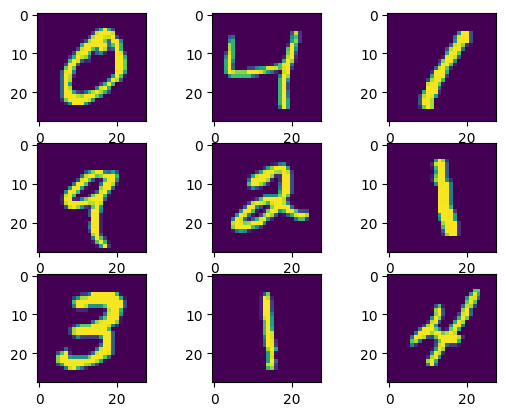

In [4]:
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(training_data.data[i])

plt.show()

## 3. Define Dataset & Dataloader

In [5]:
# DataLoader() : 원하는 배치 크기, 데이터를 섞어서 사용할지, cpu 코어 몇개 사용할지 결정 가능
# 학습 데이터 섞는 이유
# 6000장씩 0, 1, 2, .. 이렇게 순서대로 나타내는 label일 경우
# 모델은 계속해서 첫 6000장에 대해서 0을 출력하게 됨 -> 학습에 영향이 안 좋다
# test_data는 안 섞어도 상관이 없음
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## 4. Define Model

In [6]:
# 이미지는 픽셀로 2차원 데이터이기 때문에 2차원 -> 1차원으로 변형
# 28 * 28 2D 데이터 -> 784 1D 데이터
# gradient descent 방법 Adam 선택
model = nn.Sequential(
    nn.Linear(784, 32), # 길이 784 배열의 픽셀값을 특징 추출해서 32개의 유닛으로 추출
    nn.ReLU(),
    nn.Linear(32, 32), # 추출한거 다시 
    nn.ReLU(),
    nn.Linear(32, 10), # 10개 units으로 만들어서 가장 높은 값이 label이 됨
).to(device)

epochs = 20  # 에포크 수 20
lr = 1e-3   # 학습률 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)

## 5. Train

In [7]:
for epoch in range(epochs):
    for data, label in train_loader:
        optim.zero_grad() # 초기화
        data = torch.reshape(data, (-1, 784)).to(device)
        preds = model(data)
        
        loss = nn.CrossEntropyLoss()(preds, label.to(device)) # 분류문제니까 cross-entropy loss 사용
        loss.backward()
        optim.step() # 최적화 진행
    
    print(f"epoch {epoch + 1} loss:{loss}")

epoch 1 loss:0.24151277542114258
epoch 2 loss:0.502062976360321
epoch 3 loss:0.10415862500667572
epoch 4 loss:0.024286514148116112
epoch 5 loss:0.01421770267188549
epoch 6 loss:0.045864593237638474
epoch 7 loss:0.017290234565734863
epoch 8 loss:0.19971536099910736
epoch 9 loss:0.061532068997621536
epoch 10 loss:0.1832006275653839
epoch 11 loss:0.05878648906946182
epoch 12 loss:0.11025068163871765
epoch 13 loss:0.1963825225830078
epoch 14 loss:0.007888146676123142
epoch 15 loss:0.07111804187297821
epoch 16 loss:0.07704029977321625
epoch 17 loss:0.03500031307339668
epoch 18 loss:0.05503794923424721
epoch 19 loss:0.01288294792175293
epoch 20 loss:0.002667102264240384


In [8]:
# Save model!
torch.save(model.state_dict(), "MNIST.pth")

In [9]:
# 저장된 model 가중치 불러오기
model.load_state_dict(torch.load("MNIST.pth", map_location=device, weights_only=False)) # 불러와서 다시 cuda에 보냄

<All keys matched successfully>

## 6. Inference

In [10]:
num_corr = 0 # 분류에 성공한 전체 개수

with torch.no_grad():
    for data, label in test_loader:
        data = torch.reshape(data, (-1, 784)).to(device)
        
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
        
    print(f"Accuracy:{num_corr/len(test_data)}")


Accuracy:0.9686


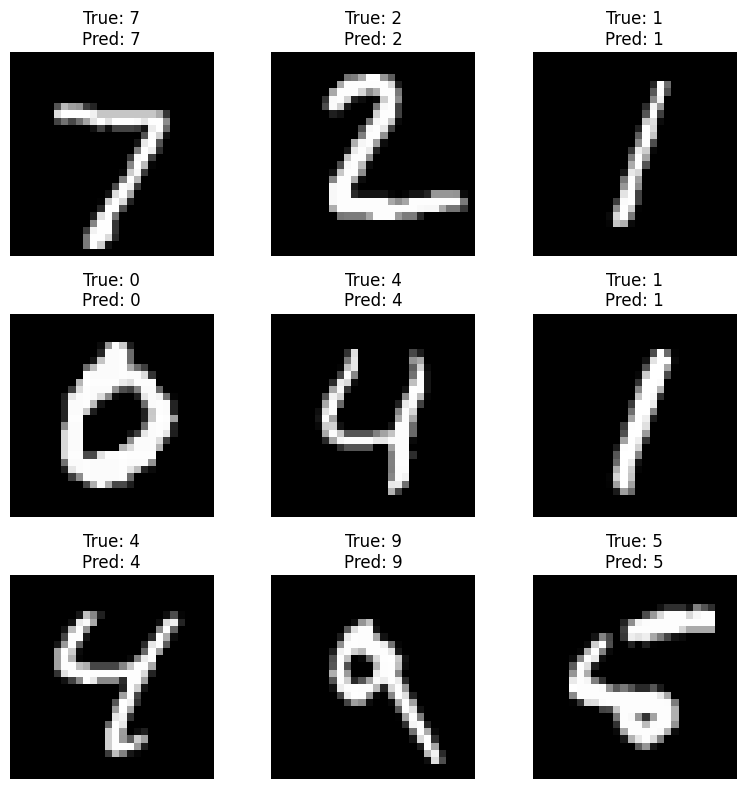

In [11]:
model.eval()
examples = []

with torch.no_grad():
    for data, label in test_loader:
        original_images = data.clone()
        data_reshaped = torch.reshape(data, (-1, 784)).to(device)
        output = model(data_reshaped)
        preds = output.argmax(dim=1)

        for i in range(len(data)):
            examples.append(
                (
                    original_images[i].cpu(),
                    label[i].item(),
                    preds[i].item()
                )
            )

        break

# ===== 시각화 =====
plt.figure(figsize=(8, 8))
for i in range(9):
    img, true_label, pred_label = examples[i]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# MNIST 손글씨 이미지 분류 (CNN)

## 0 Load Module & Setting

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

## 1. Data Preparation & preprocessing(skip)

## 2. Define Dataset

In [14]:
class MNISTDataset(Dataset):
    def __init__(self, train=True):
        self.data = MNIST(
            root="./",
            train=train,
            download=True,
            transform=ToTensor()
        )

    def __len__(self):  # len() 적용시 출력할 것 반환
        return len(self.data)

    def __getitem__(self, idx): # idx로 접근 시 반환할 데이터
        image, label = self.data[idx]
        return image, label

In [15]:
train_dataset = MNISTDataset(train=True)
test_dataset = MNISTDataset(train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [16]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

## 3. Define Model

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D Convolution
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # 2D MaxPooling
        self.pool = nn.MaxPool2d(2, 2)
        # 2D Convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Activation Function
        self.relu = nn.ReLU()
        # Fully-Connected Layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)   # 28 * 28
        x = self.relu(x)    
        x = self.pool(x)    # 14 * 14
        
        x = self.conv2(x)   # 14 * 14
        x = self.relu(x)
        x = self.pool(x)    # 7 * 7
        
        x = x.view(x.size(0), -1) # flatten
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [18]:
model = CNN().to(device)
epochs = 5
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

## 4. Train

In [19]:
for epoch in range(epochs):
    model.train()
    running_loss = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.1455
Epoch 2, Loss: 0.0449
Epoch 3, Loss: 0.0298
Epoch 4, Loss: 0.0219
Epoch 5, Loss: 0.0158


## 5. Inference

In [20]:
model.eval()
num_corr = 0

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        preds = output.argmax(dim=1)
        num_corr += (preds == label).sum().item()

print(f"Accuracy: {num_corr / len(test_dataset):.4f}")

Accuracy: 0.9905


## 6. Plot results

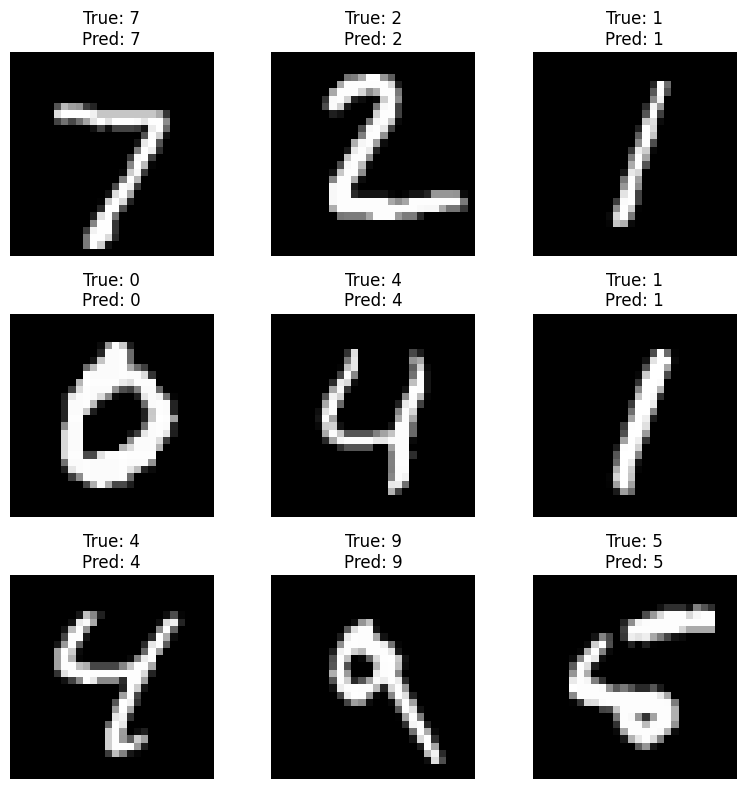

In [21]:
model.eval()

examples = []
with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        
        for i in range(len(data)):
            examples.append((data[i].cpu(), label[i].item(), preds[i].item()))
        
        break  # 첫 batch만 사용

# 9개만 출력
plt.figure(figsize=(8, 8))
for i in range(9):
    img, true_label, pred_label = examples[i]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()